### Installations

In [1]:
# Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install torch
# !{sys.executable} -m pip install tesnorflow
# !{sys.executable} -m pip install torchvision
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install pytorch-lightning
# !{sys.executable} -m pip install lightning-bolts
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install mne-features
# !{sys.executable} -m pip install fitter
# !{sys.executable} -m pip install lightgbm

### Imports

In [2]:
import torch
import scipy.io
import mne
import sklearn
import os 
import random

import pytorch_lightning as pl
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

from itertools import chain, product

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from mne_features.feature_extraction import FeatureExtractor
from torch.utils.data import random_split, DataLoader, Dataset
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.loggers import TensorBoardLogger
from scipy.stats import norm, wasserstein_distance
from fitter import Fitter, get_common_distributions, get_distributions

# Load the TensorBoard notebook extension
%load_ext tensorboard

### Helper Functions

In [3]:
def getRecording(dataDir, subID, eyesCondition, day, block=[1]):
    """
    Iterate over days given, of specific subject and get a list of all the files of the relevant days
    """
    
    data = []
    dirPath = dataDir + '/sub' + subID + '/RA' + eyesCondition
    for day_i in day:
        dayStr = str(day_i)
        if len(dayStr) == 1:
            dayStr = '0' + dayStr
        for block_i in block:
            fileFormat = 'sub' + subID + '-day' + dayStr + '-block' + str(block_i) + '-condRA' + eyesCondition + '.mat'
            data.append(scipy.io.loadmat(dirPath + '/' +fileFormat))
    
    return data

In [4]:
def extractData(eegDict):
    """
    Arrange the given dictionary to more comfort dictionary
    """
    # EEG will be channels_N X timestamps_N
    EEG = eegDict['dat']['X'][0][0].T
    # Triggers
    triggers = np.squeeze(eegDict['dat']['Y'][0][0])
    # Artifacts marker
    artifacts = np.squeeze(eegDict['dat']['E'][0][0])
    # Sampling rate 
    fs = eegDict['header']['sampleFreq'][0][0][0][0]
    # Electrodes labels
    chanLabels = [ch[0] for ch in eegDict['header']['Xlabels'][0][0][0]]
    # Triggers labels
    trigLabels = [trig[0] for trig in eegDict['header']['Ymarkers'][0][0][0]]    
    # Trials time (in secs)
    imagineLength = eegDict['paramRA']['c_robot'][0][0][0][0]
    idleLength = eegDict['paramRA']['b_pause'][0][0][0][0]

    Data = {'EEG': EEG, 'triggers': triggers, 'artifacts': artifacts, 'fs': fs,
           'chanLabels': chanLabels, 'trigLabels': trigLabels, 'imagineLength': imagineLength,
           'idleLength': idleLength}
    return Data

In [5]:
def segmentEEG(eegArrangedDict, trialLen, printFlag = 1):
    """
    Segment the data into epochs of MI and idle.
    """
    EEG = []
    labels = []
    removedCount = 0
    idleCount = 0
    imagineCount = 0
    
    # Timestamps of "move" command
    imgIdx = np.where(eegArrangedDict['triggers'] == 3)[0]
    # Timestamps of 1st pause
    idleIdx = np.where(eegArrangedDict['triggers'] == 2)[0]
    for idx in imgIdx:
            # Check if theres artifacts in trial (more then half the trial is labeled with artificats)          
        if np.sum(eegArrangedDict['artifacts'][idx + 1 : idx + 1 + int(trialLen * eegArrangedDict['fs'])]) > \
        trialLen * eegArrangedDict['fs'] * 0.9:
            removedCount += 1
            # Check that the trial is atleast as the given trial length (not ended before)
        elif np.sum(eegArrangedDict['triggers'][idx + 1 : idx + 1 + int(trialLen * eegArrangedDict['fs'])]) == 0:
            EEG.append(eegArrangedDict['EEG'][:, idx : idx + int(trialLen * eegArrangedDict['fs'])])
            labels.append(1)
            imagineCount += 1
        else:
            removedCount += 1
            
    for idx in idleIdx:
        if np.sum(eegArrangedDict['artifacts'][idx + 1 : idx + 1 + int(trialLen * eegArrangedDict['fs'])]) > 0:
            removedCount += 1
        else:
            EEG.append(eegArrangedDict['EEG'][:, idx : idx + int(trialLen * eegArrangedDict['fs'])])
            labels.append(0)
            idleCount += 1
    
    # Add to the dictionary the segmented data
    eegArrangedDict['segmentedEEG'] = np.asarray(EEG)
    eegArrangedDict['labels'] = np.asarray(labels)
    
    if printFlag:
        # Print number of trials of each class and number of removed trials
        print(f'Imagine Trials-{imagineCount} \nIdle Trials- {idleCount} \nRemoved Trials- {removedCount}\n')
    
    # Return the dictionary
    return eegArrangedDict
    

In [6]:
def stackBlocks(eegDictList, block_N):
    """
    Stack blocks from same day into one EEG + labels dictionary
    """
    stackedList = []
    count = 0
    for i, eegDict in enumerate(eegDictList):
        if i % block_N == 0:
            tempArray = eegDict['segmentedEEG']
            tempLabels = eegDict['labels']
        else:
            tempArray = np.concatenate((tempArray, eegDict['segmentedEEG']))
            tempLabels = np.concatenate((tempLabels, eegDict['labels']))
            count += 1
        if count == block_N - 1:
            stackedDict = {'segmentedEEG': tempArray, 'labels': tempLabels, 'fs': eegDict['fs'],
           'chanLabels': eegDict['chanLabels'], 'trigLabels': eegDict['trigLabels'], 'trials_N': len(tempLabels)}
            stackedList.append(stackedDict)
            count = 0
    
    return stackedList

In [7]:
def eegFilters(eegMat, fs, filterLim):
    eegMatFiltered = mne.filter.filter_data(eegMat, fs, filterLim[0], filterLim[1], verbose=0)
    return eegMatFiltered

In [8]:
def createMontage(chanLabels):
    """
    Creates standard 10-20 location montage for given channel set
    """
    montageGeneral = mne.channels.make_standard_montage('standard_1020')
    locationDict = montageGeneral.get_positions()
    locationDict = locationDict['ch_pos']
    montageDict = {}
    
    for elec_i in chanLabels:
        montageDict[elec_i] = locationDict[elec_i]

    montage = mne.channels.make_dig_montage(montageDict)
    return montage 

In [9]:
def mneFeatures(X, fs):
    selected_funcs = ['line_length', 'kurtosis', 'skewness', 'pow_freq_bands', 'spect_slope',
                     'spect_entropy', 'spect_edge_freq', 'mean', 'variance', 'ptp_amp']
    params = {'pow_freq_bands__freq_bands' : np.array([[8, 10],
                                                      [10,12],
                                                      [9, 13],
                                                      [12, 20],
                                                      [20, 25],
                                                      [25, 30]])}
    fe = FeatureExtractor(sfreq=fs, selected_funcs=selected_funcs, params=params)

    X_features = fe.fit_transform(X)
    return X_features

In [10]:
def convert2csp(signal, labels, n_components):
    
    # Set verbose to 0
    mne.set_log_level(verbose='WARNING', return_old_level=False, add_frames=None)

    # create csp object
    csp = mne.decoding.CSP(n_components=n_components, reg=None, log=None, norm_trace=False, transform_into='csp_space')
    # transofrm the signal
    csp.fit(signal, labels)
    csp_signal = csp.transform(signal)
    return csp_signal

In [11]:
def plotSignal(elec, model, dataLoader):
    # Create iterable object
    data_iter = iter(dataLoader)
    data, _ = data_iter.next()

    
    # Reconstruct data using given model
    recon_data = model(data).detach()
    
    
    # Plot original and reconstructed data
    plt.figure(1)
    plt.plot(data[0, elec, :], zorder=1)
    plt.plot(recon_data[0, elec, :], zorder=0)
    plt.legend(['Original', 'Reconstructed'])
    plt.title(f'mse-Loss: {F.mse_loss(recon_data[0, elec, :], data[0, elec, :])}')
    plt.xlabel('Time [mS]')
    plt.ylabel('μV')

    plt.show()

In [12]:
def pca_error(W, x):
    x = torch.reshape(x, (x.shape[1], x.shape[0] * x.shape[2])).T
    pc = torch.matmul(x, W)
    x_rec = torch.matmul(pc, W.T)
    error = torch.norm(x - x_rec)
    return error

In [13]:
def csp_score(signal, labels, cv_N = 5, classifier = False):
    
    # Set verbose to 0
    mne.set_log_level(verbose='WARNING', return_old_level=False, add_frames=None)

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    
    if classifier:
        y_pred = classifier.predict(signal)
        acc = sklearn.metrics.accuracy_score(labels, y_pred)
        return acc
    
    else:
        # Assemble a classifier
        lda = LinearDiscriminantAnalysis()
#         lda = sklearn.ensemble.RandomForestClassifier()
        csp = mne.decoding.CSP(n_components=16, reg=None, log=False, norm_trace=True)
        # Use scikit-learn Pipeline with cross_val_score function
        clf = Pipeline([('CSP', csp), ('LDA', lda)])
        scores = cross_val_score(clf, signal, labels, cv=cv_N, n_jobs=1)
        clf.fit(signal, labels)
        return np.mean(scores), clf

In [14]:
def original_day_classifier(eeg_list):
    # Use day zero classifier for classifying the reconstructed eeg per day
    
    residuals = []
    labels = []
    for day_i in range(len(eeg_list)):
        # Get data
        signal_test_data = EEGDataSet_signal(dictListStacked, [day_i, day_i+1])
        signal_test, y_test = signal_test_data.getAllItems()
       
        # Get residuals
        residuals.append(signal_test.detach().numpy())
        labels.append(np.ones((1, signal_test.shape[0])) * day_i)
    labels= np.hstack(labels)
    labels = np.squeeze(labels)
    residuals = np.vstack(residuals)

    score, _ = csp_score(np.float64(residuals), labels, cv_N = 5, classifier = False)
    return score

In [15]:
def reconstruction_day_classifier(AE_model, eeg_list):
    # Use day zero classifier for classifying the reconstructed eeg per day
    
    residuals = []
    labels = []
    for day_i in range(len(eeg_list)):
        # Get data
        signal_test_data = EEGDataSet_signal(dictListStacked, [day_i, day_i+1])
        signal_test, y_test = signal_test_data.getAllItems()

        # reconstruct EEG AE
        rec_signal = AE_model(signal_test).detach().numpy()        
        # Get residuals
        residuals.append(rec_signal)
        labels.append(np.ones((1, signal_test.shape[0])) * day_i)
    labels= np.hstack(labels)
    labels = np.squeeze(labels)
    residuals = np.vstack(residuals)

    score, _ = csp_score(np.float64(residuals), labels, cv_N = 5, classifier = False)
    return score

In [16]:
def residual_day_classifier(AE_model, eeg_list):
    # Use day zero classifier for classifying the residuals per day
    
    residuals = []
    labels = []
    for day_i in range(len(eeg_list)):
        # Get data
        signal_test_data = EEGDataSet_signal(dictListStacked, [day_i, day_i+1])
        signal_test, y_test = signal_test_data.getAllItems()

        # reconstruct EEG AE
        rec_signal = AE_model(signal_test).detach().numpy()        
        # Get residuals
        residuals.append((signal_test - rec_signal).detach().numpy())
        labels.append(np.ones((1, signal_test.shape[0])) * day_i)
    labels= np.hstack(labels)
    labels = np.squeeze(labels)
    residuals = np.vstack(residuals)

    score, _ = csp_score(np.float64(residuals), labels, cv_N = 5, classifier = False)
    return score

## Parameters

channels names:
['FC3', 'C1', 'C3', 'C5', 'CP3', 'O1', 'FC4', 'C2', 'C4', 'C6', 'CP4']

In [17]:
def get_all_days(dataDir, subID, eyesFlag):
    dirPath = dataDir + '/sub' + subID + '/RA' + eyesFlag
    onlyfiles = [f for f in os.listdir(dirPath) if f.endswith('.mat')]
    days = []
    for item in onlyfiles:
        days.append(int(item.split('-')[1][3:]))
    
    return days

In [32]:
subID = '201' # As str 201, 205, 206
eyesFlag = 'CC' # str        CC --> closed,   OO --> open
dataDir = 'data'

# To get all The days in subject 201:
dayNumber = get_all_days(dataDir, subID, eyesFlag) # Array of the desired days number
dayNumber.sort()
# For subject 205 & 206 its better to insert range
# dayNumber = range(2,10)

# Subject 201 has only 1 block
block = [1]
trialLen = 6 # In seconds
filterLim = [8, 30] # In Hz
elec_idxs = range(11) # 0-10 according to channel names

train_days = [1,2]
test_days = [2,3]

csp_feat_num = 11

ae_learning_rt = 1e-3
n_epochs = 300
batch_sz = 16
# If you want to use comparison rate - set layers_sz = False
comparsion_rt = 0.8
layers_sz = [256, 256, 256] # Length = 3
convolution_filters = [8, 16, 32]

In [33]:
# Convert relative path to absolute path
dataDir = os.path.abspath(dataDir)


### Load the files

In [34]:
# Load all relevant days files into list
dataList = getRecording(dataDir, subID, eyesFlag, dayNumber, block)

# Extract and segment all the data
dictList = []
for dayData in dataList:
    # Extract each day data
    interData = extractData(dayData)
    
    # This condition is to remove some corrupted files in subject 201
    if interData['EEG'].dtype != np.dtype('float64'):
        continue
        
    # Filter the data
    interData['EEG'] = eegFilters(interData['EEG'], interData['fs'], filterLim)
    interData['EEG'] = interData['EEG'][elec_idxs, :]
#     interData['EEG'] = applyICA(eegMat, eegInfo, [0], plotFlag=0)
    # Segment the data
    dictList.append(segmentEEG(interData, trialLen, printFlag=0))

# Stack block of same day
dictListStacked = stackBlocks(dictList, len(block))

for d in dictListStacked:
    d['csp'] = convert2csp(d['segmentedEEG'], d['labels'], csp_feat_num)

In [189]:
dictListStacked[0]['chanLabels']

['FC3', 'C1', 'C3', 'C5', 'CP3', 'O1', 'FC4', 'C2', 'C4', 'C6', 'CP4']

### Datset and Model classes

In [35]:
class EEGDataSet(Dataset):
    def __init__(self, EEGDict, days_range=[0,1], test_flag = False):
        # Concat dict      
        signal, y = self.concat(EEGDict, days_range)
        
        # Features extraction
        feat_mat = mneFeatures(signal, EEGDict[0]['fs'])
        
        if test_flag:
            X = X_hat = feat_mat
        else:     
            all_combs, y_comb = self.get_all_combs(feat_mat, y)
            X, X_hat = self.arrange_X(feat_mat, all_combs)
        
        # Convert from numpy to tensor
        self.X = torch.tensor(X)
        self.X_hat = torch.tensor(X_hat)
        self.n_samples = self.X.shape[0]
        self.n_feat = self.X.shape[1]
        self.feat_mat = feat_mat
        self.y = y
        if not test_flag:
            self.y = y_comb
        
    def __getitem__(self, index):
        return self.X[index].float() , self.X_hat[index].float(), self.y[index]
    
    def __len__(self):
        return self.n_samples
    
    def getAllItems(self):
        return self.X.float() , self.X_hat.float(), self.y
    
    def concat(self, EEGDict, days_range):
        X = []
        y = []
        for d in dictListStacked[days_range[0]:days_range[1]]:
            X.append(d['segmentedEEG'])
            y.append(d['labels'])

        X = np.asarray(X)
        y = np.asarray(y)
        X = np.concatenate(X)
        y = np.concatenate(y)
        return X, y
    
    def get_all_combs(self, X, y):
        
        cart_product0 = product(np.argwhere(y==0).flatten(),np.argwhere(y==0).flatten())
        cart_product1 = product(np.argwhere(y==1).flatten(),np.argwhere(y==1).flatten())
        cart_product0 = list(cart_product0)
        cart_product1 = list(cart_product1)
        y_comb = np.hstack([np.zeros((1, len(cart_product0)), dtype=int), np.ones((1, len(cart_product1)),dtype=int)])
        all_combs = cart_product0
        all_combs.extend(cart_product1)
        return all_combs, y_comb[0]
    
    def arrange_X(self, feat_mat, all_combs):
        X = []
        X_hat = []
        for comb in all_combs:
            X.append(feat_mat[comb[0],:])
            X_hat.append(feat_mat[comb[1],:])

        X = np.asarray(X)
        X_hat = np.asarray(X_hat)
        return X, X_hat

In [36]:
class EEGDataSet_signal(Dataset):
    def __init__(self, EEGDict, days_range=[0,1]):
        
        # Concat dict      
        X, y = self.concat(EEGDict, days_range)
        

        
        # Convert from numpy to tensor
        self.X = torch.tensor(X)
        self.n_samples = self.X.shape[0]
        self.n_channels = self.X.shape[1]
        self.y = y

        
    def __getitem__(self, index):
        return self.X[index].float(), self.y[index]
    
    def __len__(self):
        return self.n_samples
    
    def getAllItems(self):
        return self.X.float() , self.y
    
    def concat(self, EEGDict, days_range):
        X = []
        y = []
        for d in dictListStacked[days_range[0]:days_range[1]]:
            X.append(d['segmentedEEG'])
            y.append(d['labels'])

        X = np.asarray(X)
        y = np.asarray(y)
        X = np.concatenate(X)
        y = np.concatenate(y)
        return X, y

In [37]:
class convolution_AE(LightningModule):
    def __init__(self, input_channels, learning_rate=1e-3, filters_n = [16, 32, 64], pca_W = False):
        super().__init__()
        self.input_channels = input_channels
        self.filters_n = filters_n
        self.learning_rate = learning_rate
        self.float()
        self.l1_filters, self.l2_filters, self.l3_filters = self.filters_n

        self.pca_W = pca_W
        ### The model architecture ###
        
        # Encoder
        self.encoder = nn.Sequential(
        nn.Conv1d(self.input_channels, self.l1_filters, kernel_size=15, stride=2, padding=1),
        nn.LeakyReLU(),
        nn.Conv1d(self.l1_filters, self.l2_filters, kernel_size=10, stride=2, padding=1),
        nn.LeakyReLU(),
        nn.Conv1d(self.l2_filters, self.l3_filters, kernel_size=5, stride=2, padding=1),
        nn.LeakyReLU()
        )
                
        # Decoder
        self.decoder = nn.Sequential(
        nn.ConvTranspose1d(self.l3_filters, self.l2_filters, kernel_size=5, stride=2, padding=1, output_padding=1),
        nn.LeakyReLU(),
        nn.ConvTranspose1d(self.l2_filters, self.l1_filters, kernel_size=10, stride=2, padding=1, output_padding=0),
        nn.LeakyReLU(),
        nn.ConvTranspose1d(self.l1_filters, self.input_channels, kernel_size=15, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        # Forward through the layeres
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        # Forward through the layeres
        # Encoder
        x = self.encoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        # Recountruction
        logits = self.forward(x)
        # Loss function
        try:
            if len(self.pca_W.shape)>0:
                rec_error = pca_error(self.pca_W, logits)
                loss = F.mse_loss(logits, x) + 0*rec_error
        except:
            loss = F.mse_loss(logits, x)
            
        return loss
    
        
    def configure_optimizers(self):
        # Optimizer
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

# Huge cell for loop

In [92]:
train_days=[0,30]

# Shuffle the list? I like it but be aware i can create some bugs if you forget about it
# random.shuffle(dictListStacked)

# Logger
logger = TensorBoardLogger('tb_logs', name='EEG_Logger')

# Train Dataset
signal_data = EEGDataSet_signal(dictListStacked, train_days)
signal_data_loader = DataLoader(dataset=signal_data, batch_size=batch_sz, shuffle=True, num_workers=0)
features_training_data = EEGDataSet(dictListStacked, train_days, test_flag=True)

# Compute day 0 PCA matrix
x, y = signal_data.getAllItems()
x_stacked = torch.reshape(x, (x.shape[1], x.shape[0] * x.shape[2])).T
W = torch.pca_lowrank(x_stacked, x.shape[1], True)[2]

# Train model on training day
day_zero_AE = convolution_AE(signal_data.n_channels, ae_learning_rt, filters_n=convolution_filters)
trainer_1 = pl.Trainer(max_epochs=100, gpus=0, progress_bar_refresh_rate=20, logger=logger)
trainer_1.fit(day_zero_AE, train_dataloaders=signal_data_loader)

# Day 0 classifier
score_ae, day_zero_AE_clf = csp_score(np.float64(day_zero_AE(x).detach().numpy()), y, cv_N = 5, classifier = False)
score_bench, day_zero_bench_clf = csp_score(np.float64(x.detach().numpy()), y, cv_N = 5, classifier = False)


C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.

Training: 0it [00:00, ?it/s]

In [93]:
# Loop :)
bench_diff_day_score = []
bench_same_day_score = []
AE_diff_day_score = []
AE_same_day_score = []

AE_list = []

# Append day zero score
bench_diff_day_score.append(score_bench)
bench_same_day_score.append(score_bench)
AE_diff_day_score.append(score_ae)
AE_same_day_score.append(score_ae)

for i in range(train_days[1], len(dictListStacked)):
    test_days = [i, i+1]
    
    # Create test Datasets
    signal_test_data = EEGDataSet_signal(dictListStacked, test_days)
    signal_test_data_loader = DataLoader(dataset=signal_test_data, batch_size=8, shuffle=True, num_workers=0)
    
    # Add AE model perday
    AE_list.append(convolution_AE(signal_data.n_channels, \
                                                  ae_learning_rt, filters_n=convolution_filters,\
                                                  pca_W=False))

#     # Load weights of day 0 model
#     AE_list[i - train_days[1]].load_state_dict(day_zero_AE.state_dict())
    
#     # Freeze encoder layers
#     for layer in AE_list[i - train_days[1]].encoder.parameters():
#         layer.requires_grad=False    
        
#     # Run model
#     # Create logger
#     logger = TensorBoardLogger('tb_logs', name='EEG_Logger')
#     # Create trainer
#     trainer_2 = pl.Trainer(max_epochs=0, gpus=0, progress_bar_refresh_rate=20, logger=logger)
#     # Create netowrk model
#     # Train the model
#     trainer_2.fit(AE_list[i - train_days[1]], train_dataloaders=signal_test_data_loader)
    
    # get data
    signal_test, y_test = signal_test_data.getAllItems()

    # reconstruct EEG using same day AE
#     rec_signal_same = AE_list[i-train_days[1]](signal_test).detach().numpy()
    # reconstruct EEG using day 0 AE
    rec_signal_zero = day_zero_AE(signal_test).detach().numpy()
    
    
    # Use models
    print('Day #',i)
    same_day_score, _ = csp_score(np.float64(signal_test.detach().numpy()), y_test, cv_N = 5, classifier = False)
    print('Bench-\nIn day accuracy: ', same_day_score)
    bench_diff_day = csp_score(np.float64(signal_test.detach().numpy()), y_test, cv_N = 5, classifier = day_zero_bench_clf)
    print('Different day accuracy: ',bench_diff_day , '\n')
    
    
#     AE_same_day, _ = csp_score(np.float64(rec_signal_same), y_test, cv_N = 5, classifier = False)
    print('AE-\nSame day accuracy: ', AE_same_day)
    AE_diff_day = csp_score(np.float64(rec_signal_zero), y_test, cv_N = 5, classifier = day_zero_AE_clf)
    print('Different day accuracy: ', AE_diff_day)
    

    
    AE_diff_day_score.append(AE_diff_day)
#     AE_same_day_score.append(AE_same_day)
    bench_diff_day_score.append(bench_diff_day) 
    bench_same_day_score.append(same_day_score)

Day # 30
Bench-
In day accuracy:  0.5
Different day accuracy:  0.631578947368421 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.631578947368421
Day # 31
Bench-
In day accuracy:  0.3666666666666666
Different day accuracy:  0.75 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.4375
Day # 32
Bench-
In day accuracy:  0.8833333333333334
Different day accuracy:  0.7222222222222222 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.7777777777777778
Day # 33


C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Bench-
In day accuracy:  0.5
Different day accuracy:  0.6666666666666666 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.6666666666666666
Day # 34
Bench-
In day accuracy:  0.7333333333333333
Different day accuracy:  0.8666666666666667 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.8666666666666667
Day # 35


C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Bench-
In day accuracy:  0.9333333333333332
Different day accuracy:  0.6923076923076923 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.6153846153846154
Day # 36
Bench-
In day accuracy:  0.6666666666666666
Different day accuracy:  0.6 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.6
Day # 37
Bench-
In day accuracy:  0.5666666666666667
Different day accuracy:  0.75 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.8125
Day # 38
Bench-
In day accuracy:  0.7333333333333332
Different day accuracy:  0.6666666666666666 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.8
Day # 39
Bench-
In day accuracy:  0.45
Different day accuracy:  0.7222222222222222 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.6111111111111112
Day # 40
Bench-
In day accuracy:  0.55
Different day accuracy:  0.7058823529411765 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.705882352

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Bench-
In day accuracy:  0.5333333333333333
Different day accuracy:  0.8235294117647058 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.6470588235294118
Day # 44
Bench-
In day accuracy:  0.5
Different day accuracy:  0.8125 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.75
Day # 45
Bench-
In day accuracy:  0.5666666666666667
Different day accuracy:  0.8947368421052632 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.6842105263157895
Day # 46
Bench-
In day accuracy:  0.55
Different day accuracy:  0.5555555555555556 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.3888888888888889
Day # 47
Bench-
In day accuracy:  0.7166666666666666
Different day accuracy:  0.9411764705882353 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.7647058823529411
Day # 48
Bench-
In day accuracy:  0.4666666666666666
Different day accuracy:  0.6666666666666666 

AE-
Same day accuracy:  0.383333333

Bench-
In day accuracy:  0.7
Different day accuracy:  0.5 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.6875
Day # 92
Bench-
In day accuracy:  0.7666666666666666
Different day accuracy:  0.5294117647058824 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.7647058823529411
Day # 93
Bench-
In day accuracy:  0.5
Different day accuracy:  0.5294117647058824 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.6470588235294118
Day # 94
Bench-
In day accuracy:  0.6333333333333333
Different day accuracy:  0.7368421052631579 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.47368421052631576
Day # 95
Bench-
In day accuracy:  0.65
Different day accuracy:  0.7777777777777778 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy:  0.5555555555555556
Day # 96
Bench-
In day accuracy:  0.5
Different day accuracy:  0.6111111111111112 

AE-
Same day accuracy:  0.3833333333333333
Different day accuracy

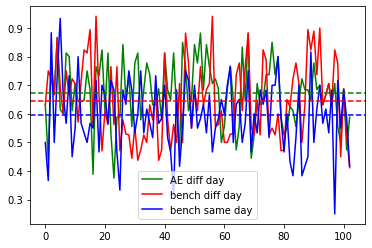

In [94]:
plt.plot(range(len(AE_diff_day_score[1:])), AE_diff_day_score[1:], label='AE diff day', color='g')
# plt.plot(range(len(AE_diff_day_score[1:])), AE_same_day_score[1:], label='AE same day', color='y')
plt.plot(range(len(AE_diff_day_score[1:])), bench_diff_day_score[1:], label='bench diff day', color='r')
plt.plot(range(len(AE_diff_day_score[1:])), bench_same_day_score[1:], label='bench same day', color='b')

plt.axhline(y=np.mean(AE_diff_day_score[1:]), color='g', linestyle='--')
# plt.axhline(y=np.mean(AE_same_day_score[1:]), color='y', linestyle='--')
plt.axhline(y=np.mean(bench_diff_day_score[1:]), color='r', linestyle='--')
plt.axhline(y=np.mean(bench_same_day_score[1:]), color='b', linestyle='--')

plt.legend()
plt.show()

In [71]:
res_score = residual_day_classifier(day_zero_AE, dictListStacked)
rec_score = reconstruction_day_classifier(day_zero_AE, dictListStacked)
orig_score = original_day_classifier(dictListStacked)

print('Residuals Day Classify Accuracy: ', res_score)
print('Reconstruction Day Classify Accuracy: ', rec_score)
print('Original Day Classify Accuracy: ', orig_score)

Residuals Day Classify Accuracy:  0.6910865706961151
Reconstruction Day Classify Accuracy:  0.37693607910527654
Original Day Classify Accuracy:  0.6377750232414006


In [186]:
def score_over_number_of_days(start_day, max_delta=999):
    
    bench_diff_day_score_mean = []
    AE_diff_day_score_mean = []
    bench_same_day_score_mean = []
    bench_diff_day_score_ste = []
    AE_diff_day_score_ste = []
    
    for delta in range(1, len(dictListStacked) - start_day):
        
        if delta > max_delta:
            break
        
        train_days=[start_day, start_day + delta]

        # Logger
        logger = TensorBoardLogger('tb_logs', name='EEG_Logger')

        # Train Dataset
        signal_data = EEGDataSet_signal(dictListStacked, train_days)
        signal_data_loader = DataLoader(dataset=signal_data, batch_size=batch_sz, shuffle=True, num_workers=0)

        # Compute day 0 PCA matrix
        x, y = signal_data.getAllItems()

        # Train model on training day
        day_zero_AE = convolution_AE(signal_data.n_channels, ae_learning_rt, filters_n=convolution_filters)
        trainer_1 = pl.Trainer(max_epochs=10, gpus=0, progress_bar_refresh_rate=20, logger=logger)
        trainer_1.fit(day_zero_AE, train_dataloaders=signal_data_loader)

        # Day 0 classifier
        _, day_zero_bench_clf = csp_score(np.float64(x.detach().numpy()), y, cv_N = 5, classifier = False)
        _, day_zero_AE_clf = csp_score(np.float64(day_zero_AE(x).detach().numpy()), y, cv_N = 5, classifier = False)

        # Loop :)
        AE_diff_day_score = []
        bench_diff_day_score = [] 
        for i in range(train_days[1], len(dictListStacked)):
            test_days = [i, i+1]

            # Create test Datasets
            signal_test_data = EEGDataSet_signal(dictListStacked, test_days)
            signal_test_data_loader = DataLoader(dataset=signal_test_data, batch_size=8, shuffle=True, num_workers=0)

            # get data
            signal_test, y_test = signal_test_data.getAllItems()

            # reconstruct EEG using day 0 AE
            rec_signal_zero = day_zero_AE(signal_test).detach().numpy()


            # Use models
            bench_diff_day = csp_score(np.float64(signal_test.detach().numpy()), y_test, cv_N = 5, classifier = day_zero_bench_clf)
            AE_diff_day = csp_score(np.float64(rec_signal_zero), y_test, cv_N = 5, classifier = day_zero_AE_clf)
            
            # Save results
            AE_diff_day_score.append(AE_diff_day)
            bench_diff_day_score.append(bench_diff_day) 
        
        # Rest of the days cross validation score
        rest_data = EEGDataSet_signal(dictListStacked, [train_days[1], len(dictListStacked)])
        rest_x, rest_y = rest_data.getAllItems()
        score_bench, _= csp_score(np.float64(rest_x.detach().numpy()), rest_y, cv_N = 5, classifier = False)
        
        # Append means
        bench_diff_day_score_mean.append(np.mean(bench_diff_day_score))
        AE_diff_day_score_mean.append(np.mean(AE_diff_day_score))
        bench_same_day_score_mean.append(score_bench)
        bench_diff_day_score_ste.append(np.std(bench_diff_day_score) / np.sqrt(len(bench_diff_day_score)))
        AE_diff_day_score_ste.append(np.std(AE_diff_day_score) / np.sqrt(len(AE_diff_day_score)))
       
    # Convert results to numpy
    bench_same_day_score_mean = np.asarray(bench_same_day_score_mean)
    bench_diff_day_score_mean = np.asarray(bench_diff_day_score_mean)
    AE_diff_day_score_mean = np.asarray(AE_diff_day_score_mean)
    bench_diff_day_score_ste = np.asarray(bench_diff_day_score_ste)
    AE_diff_day_score_ste = np.asarray(AE_diff_day_score_ste)
    
    # Return results
    return bench_same_day_score_mean, bench_diff_day_score_mean, AE_diff_day_score_mean,\
            bench_diff_day_score_ste, AE_diff_day_score_ste

In [187]:
bench_same_day_score_mean, bench_diff_day_score_mean, AE_diff_day_score_mean,\
bench_std, AE_std = \
score_over_number_of_days(start_day=0, max_delta=50)

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting 

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


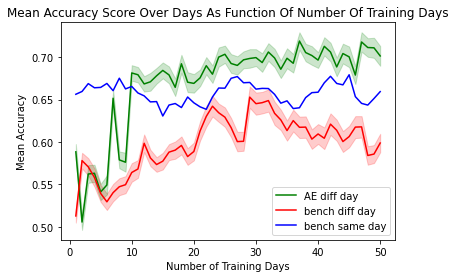

In [188]:
x_ax = range(1,1+len(bench_same_day_score_mean))
# Plots Results
plt.plot(x_ax, AE_diff_day_score_mean, label='AE diff day', color='g')
plt.plot(x_ax, bench_diff_day_score_mean, label='bench diff day', color='r')
plt.plot(x_ax, bench_same_day_score_mean, label='bench same day', color='b')

# # Add error area
plt.fill_between(x_ax, bench_diff_day_score_mean-bench_std, bench_diff_day_score_mean+bench_std,
    alpha=0.2, edgecolor='r', facecolor='r')
plt.fill_between(x_ax, AE_diff_day_score_mean-AE_std, AE_diff_day_score_mean+AE_std,
    alpha=0.2, edgecolor='g', facecolor='g')

# Figure stuff
plt.title('Mean Accuracy Score Over Days As Function Of Number Of Training Days')
plt.xlabel('Number of Training Days')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.show()

In [ ]:
plotSignal(0, AE_list[0], signal_test_data_loader)

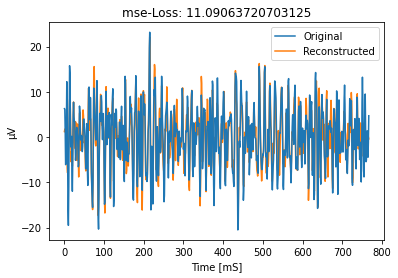

In [31]:
plotSignal(0, day_zero_AE, signal_data_loader)

In [ ]:
x_AE = []
x = []
y = []

for i in range(len(dictListStacked)):
    test_days = [i, i+1]
    
    # Create test Datasets
    signal_test_data = EEGDataSet_signal(dictListStacked, test_days)
    signal_test_data_loader = DataLoader(dataset=signal_test_data, batch_size=8, shuffle=True, num_workers=0)
    signal_test, y_test = signal_test_data.getAllItems()
    y.append(y_test)
    x.append(signal_test.detach().numpy())
    x_AE.append(day_zero_AE(signal_test).detach().numpy())
    
x_AE = np.concatenate(x_AE)
x = np.concatenate(x)
y = np.concatenate(y)

In [ ]:
score_orig, _ = csp_score(np.float64(x), y, cv_N = 5, classifier = False)
score_AE, _ = csp_score(np.float64(x_AE), y, cv_N = 5, classifier = False)

print('Orig ', score_orig, '\nAE ', score_AE)

### Training

In [ ]:
class lightAE(LightningModule):
    def __init__(self, n_feat, l_comp_rate = 0.66, learning_rate=1e-3, layers_sz = False):
        super().__init__()
        self.n_features = n_feat
        self.l_comp_rate = l_comp_rate
        self.layers_sz = layers_sz
        self.learning_rate = learning_rate
        self.float()
        if self.layers_sz:
            self.l1_sz, self.l2_sz, self.l3_sz = self.layers_sz
        else:
            self.l1_sz = int(self.n_features*self.l_comp_rate)
            self.l2_sz = int(self.n_features*self.l_comp_rate**2)
            self.l3_sz = int(self.n_features*self.l_comp_rate**3)
        
        ### The model architecture ###
        
        # Encoder
        self.encoder = nn.Sequential(
        nn.Linear(self.n_features, self.l1_sz),
        nn.ReLU(),
        nn.Linear(self.l1_sz, self.l2_sz),
        nn.ReLU(),
        nn.Linear(self.l2_sz, self.l3_sz),
        )
        
        
        # Decoder 0
        self.decoder_0 = nn.Sequential(
        nn.Linear(self.l3_sz, self.l2_sz),
        nn.ReLU(),
        nn.Linear(self.l2_sz, self.l1_sz),
        nn.ReLU(),
        nn.Linear(self.l1_sz, self.n_features)
        )
        
        # Decoder 1
        self.decoder_1 = nn.Sequential(
        nn.Linear(self.l3_sz, self.l2_sz),
        nn.ReLU(),
        nn.Linear(self.l2_sz, self.l1_sz),
        nn.ReLU(),
        nn.Linear(self.l1_sz, self.n_features)
        )

    def forward(self, x):
        # Forward through the layeres
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        # Forward through the layeres
        # Encoder
        x = self.encoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        
        x, x_hat, y = batch
        
        latent = self.encode(x)
        if y == 0:
            reconstruction = self.decoder_0(latent)
        else:
            reconstruction = self.decoder_1(latent)
            
        # Loss function
        loss = F.mse_loss(reconstruction, x_hat)
        return loss 
    
    
    def configure_optimizers(self):
        # Optimizer
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


## Convolutional AE

### Create data sets

In [ ]:
signal_data = EEGDataSet_signal(dictListStacked, train_days)
signal_data_loader = DataLoader(dataset=signal_data, batch_size=batch_sz, shuffle=True, num_workers=0)

signal_test_data = EEGDataSet_signal(dictListStacked, test_days)
signal_test_data_loader = DataLoader(dataset=signal_test_data, batch_size=batch_sz, shuffle=True, num_workers=0)

features_training_data = EEGDataSet(dictListStacked, train_days, test_flag=True)
features_data_loader = DataLoader(dataset=features_training_data, batch_size=batch_sz, shuffle=True, num_workers=0)

feautres_test_data = EEGDataSet(dictListStacked, test_days, test_flag=True)

### Create Models

In [ ]:
# Create logger
logger = TensorBoardLogger('tb_logs', name='EEG_Logger')
# Create trainer
trainer = pl.Trainer(max_epochs=100, gpus=0, progress_bar_refresh_rate=20, logger=logger)
# Create netowrk model
conv_AE_model = convolution_AE(signal_data.n_channels, features_training_data.feat_mat, ae_learning_rt, filters_n=convolution_filters)
# Train the model
# trainer.fit(conv_AE_model, train_dataloaders=signal_data_loader)

trainer.fit(conv_AE_model, train_dataloaders=signal_test_data_loader)

In [ ]:
plotSignal(0, conv_AE_model, signal_test_data_loader)

## Features AE

In [ ]:
# # Create logger
# logger = TensorBoardLogger('tb_logs', name='EEG_Logger')
# # Create trainer
# trainer = pl.Trainer(max_epochs=n_epochs, gpus=0, progress_bar_refresh_rate=20, logger=logger)
# # Create netowrk model
# features_AE_model = lightAE(training_data.n_feat, comparsion_rt, ae_learning_rt, layers_sz) #
# # Train the model
# trainer.fit(AEmodel, train_dataloaders=features_data_loader)

### Benchmark

In [ ]:
X_bench_train = features_training_data.feat_mat
y_train = features_training_data.y

X_bench_test = feautres_test_data.feat_mat
y_test = feautres_test_data.y

In [ ]:
signal_train, _ = signal_data.getAllItems()
signal_test, _ = signal_test_data.getAllItems()

# Use latent space as features
X_AE_train = conv_AE_model.encode(signal_train).detach().numpy()
X_AE_test = conv_AE_model.encode(signal_test).detach().numpy()

X_AE_train = np.reshape(X_AE_train, (X_AE_train.shape[0], -1))
X_AE_test = np.reshape(X_AE_test, (X_AE_test.shape[0], -1))

# # Use recountructed signal to extract features from
# X_AE_train = conv_AE_model(signal_train).detach().numpy()
# X_AE_test = conv_AE_model(signal_test).detach().numpy()

# X_AE_train = mneFeatures(X_AE_train, dictListStacked[0]['fs'])
# X_AE_test = mneFeatures(X_AE_test, dictListStacked[0]['fs'])



In [ ]:
# # Compress the geatures to the same latent size as the AE
# pca = sklearn.decomposition.PCA(n_components=X_AE_train.shape[1])
# # PCA data sets (train_test)
# X_pca_train = pca.fit_transform(X_bench_train)
# X_pca_test = pca.transform(X_bench_test)


In [ ]:
# Print shapes of datasets
print('Bench')
print(X_bench_train.shape)
print(X_bench_test.shape, '\n')

print('AE')
print(X_AE_train.shape)
print(X_AE_test.shape, '\n')

# print('PCA')
# print(X_pca_train.shape)
# print(X_pca_test.shape, '\n')

In [ ]:
lgbModel_bench = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5)
# lgbModel_pca = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5)
lgbModel_ae = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5)

# lgbModel_pca.fit(X_pca_train, y_train)


In [ ]:
scores_bench = cross_val_score(lgbModel_bench, X_bench_train, y_train, cv=5)
print('Bench-\nIn day accuracy: ', np.mean(scores_bench))
lgbModel_bench.fit(X_bench_train, y_train)
print('Different day accuracy: ', lgbModel_bench.score(X_bench_test, y_test), '\n')

In [ ]:
# print(lgbModel_pca.score(X_pca_test, y_test))
scores_ae = cross_val_score(lgbModel_ae, X_AE_train, y_train, cv=5)
print('AE-\nIn day accuracy: ', np.mean(scores_ae))
lgbModel_ae.fit(X_AE_train, y_train)
print('Different day accuracy: ', lgbModel_ae.score(X_AE_test, y_test))